In [1]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import folium
import geojson

In [2]:
posters = pd.read_csv('./dummy/p.csv')

posters['ID'] = posters['ID'].apply(lambda x : 'P' + str(x))

posters = posters.set_index('ID')

geometry = [Point(lon,lat) for lon, lat in zip(posters['longitude'], posters['latitude'] )]

posters_gdf = gpd.GeoDataFrame(posters, geometry=geometry,crs='EPSG:4326' )

posters_gdf = posters_gdf.to_crs("epsg:31370")

posters_gdf.head()



,latitude,longitude,geometry
ID,,,
P22,51.278824,4.409519,POINT (152844.191 218773.503)
P49,51.182657,4.372914,POINT (150290.660 208073.635)
P65,51.185132,4.344203,POINT (148283.183 208349.244)
P77,51.171207,4.364278,POINT (149686.737 206799.787)
P78,51.171212,4.364441,POINT (149698.166 206800.342)


In [3]:
with open('./dummy/test_geo.geojson', 'r') as f:
    gj = geojson.load(f)

gj.is_valid

gj


{"bbox": [4.339824, 51.181978, 4.502609, 51.29985], "features": [{"geometry": {"coordinates": [[[4.339824, 51.248737], [4.340451, 51.248408], [4.343983, 51.246483], [4.346526, 51.245097], [4.352176, 51.242434], [4.352568, 51.242262], [4.35402, 51.241756], [4.359701, 51.242208], [4.364392, 51.242165], [4.373556, 51.242078], [4.377583, 51.240024], [4.378325, 51.240062], [4.383114, 51.241965], [4.385685, 51.242194], [4.389668, 51.241654], [4.393454, 51.241068], [4.396203, 51.240497], [4.395849, 51.228925], [4.391844, 51.228999], [4.388357, 51.229045], [4.38487, 51.22909], [4.384865, 51.22909], [4.383945, 51.2291], [4.383907, 51.225501], [4.392369, 51.21758], [4.393633, 51.215162], [4.393943, 51.215045], [4.395309, 51.215502], [4.403291, 51.218089], [4.405392, 51.218239], [4.415057, 51.21493], [4.420493, 51.208673], [4.415214, 51.200288], [4.410469, 51.194409], [4.403821, 51.19385], [4.400582, 51.194868], [4.39705, 51.196159], [4.394379, 51.197193], [4.38989, 51.198751], [4.389512, 51.1988

In [4]:
poi = gpd.read_file("./dummy/test_geo.geojson",crs='EPSG:4326').set_index('name')
poi = poi.to_crs("epsg:31370")

poi

,group_index,value,geometry
name,,,
Meir,0,600.0,"POLYGON ((147979.713 215425.694, 148023.479 21..."


In [5]:
dt = Polygon(gj['features'][0]['geometry']['coordinates'][0])
dt_lon, dt_lat = gj['features'][0]['properties']['center']
map = folium.Map(location=(dt_lat,dt_lon), tiles="cartodbpositron", min_zoom=11)

folium.Marker((dt_lat,dt_lon)).add_to(map)

for index,row in posters_gdf.iterrows():
    lon = row['longitude']
    lat = row['latitude']
    point = Point(lon,lat)

    if point.within(dt) or point.touches(dt):
        folium.Marker(location= [lat, lon],popup=index, icon= folium.Icon(color='red', icon='star') ).add_to(map)
        folium.Circle([lat, lon],radius=300, color='red', fill_color = 'red').add_to(map)

    else:
        folium.Marker(location= [lat, lon],popup=index, icon= folium.Icon(color='cadetblue', icon='star') ).add_to(map)


folium.features.GeoJson(gj).add_to(map)

map

In [6]:
distances = posters_gdf.geometry.distance(poi.loc['Meir'].geometry.centroid)

distances

ID
P22     4392.847213
P49     7223.795326
P65     8144.531003
P77     8632.413088
P78     8626.653746
           ...     
P655    4650.372728
P361    4921.374554
P929    3886.850563
P681    5169.673976
P256    4988.926952
Length: 111, dtype: float64

In [7]:
buffer = posters_gdf.geometry.buffer(300)
print(type(buffer))
buffer.crs


<class 'geopandas.geoseries.GeoSeries'>


<Derived Projected CRS: EPSG:31370>
Name: BD72 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

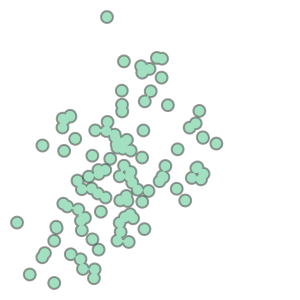

In [9]:
buffer_union = buffer.geometry.unary_union
buffer_union

In [10]:
buffer = gpd.GeoSeries(buffer_union, crs="epsg:31370")
buffer = buffer.explode(index_parts=True)



folium.features.GeoJson(buffer.to_crs(epsg=4324)).add_to(map)

map

In [30]:
# for index, row in buffer.items():
#     print(index[1])

def get_buffer_id(point):
    for index, row in buffer.items():
        if point.within(row):
            return index

posters_gdf['buffer_id'] = posters_gdf['geometry'].apply(lambda x : get_buffer_id(x))

posters_gdf

,latitude,longitude,geometry,buffer_id
ID,,,,
P22,51.278824,4.409519,POINT (152844.191 218773.503),"(0, 22)"
P49,51.182657,4.372914,POINT (150290.660 208073.635),"(0, 5)"
P65,51.185132,4.344203,POINT (148283.183 208349.244),"(0, 6)"
P77,51.171207,4.364278,POINT (149686.737 206799.787),"(0, 3)"
P78,51.171212,4.364441,POINT (149698.166 206800.342),"(0, 3)"
...,...,...,...,...
P655,51.220294,4.362614,POINT (149570.786 212260.899),"(0, 10)"
P361,51.196552,4.408381,POINT (152769.782 209620.255),"(0, 8)"
P929,51.217813,4.378362,POINT (150671.062 211984.912),"(0, 9)"


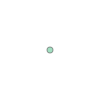

In [36]:
buffer.loc[(0,3)].centroid

In [59]:
# for each buffer_id
# get a sub posters_gdf containing only the rows that contain same buffer_id
# calculate distance to centroid, and eliminate panel from group
# do this until buffers contain only one point

for index, row in buffer.items():
    sub_gdf = posters_gdf.loc[posters_gdf['buffer_id'] == index]
    if len(sub_gdf) > 1:
        dist_to_centroid = sub_gdf.geometry.distance(row.centroid)
        print(dist_to_centroid.idxmin())

P189
P77
P84
P878
P357
P656
P341
P283
P427
P355
P785
P576
P900
P141
P293
P545
P912
P301
P249
P135
